In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import PIL
from PIL import Image
from skimage.color import rgb2gray
from scipy import ndimage as ndi
import cv2
import os
from os import listdir
from sklearn.utils import shuffle
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
directory_root = "PlantVillage/"
print(len(listdir(directory_root)))

11


In [3]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        for image in plant_disease_folder_list:
            image_directory = f"{directory_root}/{plant_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list.append(image_directory)
                label_list.append(plant_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Image loading completed


In [4]:
img_info = pd.DataFrame({'image_path':image_list,'label':label_list})
print(img_info.head())
print(len(img_info))

                                          image_path  \
0  PlantVillage//Pepper__bell___Bacterial_spot/04...   
1  PlantVillage//Pepper__bell___Bacterial_spot/04...   
2  PlantVillage//Pepper__bell___Bacterial_spot/04...   
3  PlantVillage//Pepper__bell___Bacterial_spot/05...   
4  PlantVillage//Pepper__bell___Bacterial_spot/05...   

                           label  
0  Pepper__bell___Bacterial_spot  
1  Pepper__bell___Bacterial_spot  
2  Pepper__bell___Bacterial_spot  
3  Pepper__bell___Bacterial_spot  
4  Pepper__bell___Bacterial_spot  
13358


In [5]:
img_info["labels_integer"] = None
#index of new column
index_labels_integer = img_info.columns.get_loc("labels_integer")
#index of species column
index_species = img_info.columns.get_loc("label")
#to assign numeric labels starting with 0 for the first species
k = 0 
for i in range(len(img_info)):
    if i == 0:
        img_info.iloc[i, index_labels_integer] = k #here, k == 0
    if i > 0:
        if img_info.iloc[i-1, index_species] == img_info.iloc[i, index_species]:
            img_info.iloc[i, index_labels_integer] = k
        else:
            k += 1
            img_info.iloc[i, index_labels_integer] = k
img_info.head()

,image_path,label,labels_integer
0,PlantVillage//Pepper__bell___Bacterial_spot/04...,Pepper__bell___Bacterial_spot,0
1,PlantVillage//Pepper__bell___Bacterial_spot/04...,Pepper__bell___Bacterial_spot,0
2,PlantVillage//Pepper__bell___Bacterial_spot/04...,Pepper__bell___Bacterial_spot,0
3,PlantVillage//Pepper__bell___Bacterial_spot/05...,Pepper__bell___Bacterial_spot,0
4,PlantVillage//Pepper__bell___Bacterial_spot/05...,Pepper__bell___Bacterial_spot,0


In [6]:
import PIL.Image
if not hasattr(PIL.Image, 'Resampling'):  # Pillow<9.0
    PIL.Image.Resampling = PIL.Image
  # Now PIL.Image.Resampling.BICUBIC is always recognized.img_info = shuffle(img_info)
list_vectors = []

for image_path in img_info.image_path:
    #read as rgb array
    img = Image.open(image_path)
    size = (64, 64)
    img = img.resize(size, PIL.Image.Resampling.LANCZOS)
    img_array = np.array(img)
    #append image vector to list
    list_vectors.append(img_array)
    
print(len(list_vectors))


13358


In [7]:
X = np.stack((list_vectors))
Y =  img_info['labels_integer']
print(X.shape)

(13358, 64, 64, 3)


In [8]:
X = X/255
Y_one_hot = keras.utils.np_utils.to_categorical(Y, num_classes=15)
print(Y.shape, Y_one_hot.shape)

(13358,) (13358, 15)


In [9]:
np.savez("x_images_arrayscnn", X)
np.savez("y_numeric_labelscnn", Y_one_hot)

In [10]:
x_npz = np.load("x_images_arrayscnn.npz")
X = x_npz['arr_0']

y_npz = np.load("y_numeric_labelscnn.npz")
Y_one_hot = y_npz['arr_0']

print(X.shape)

(13358, 64, 64, 3)


In [11]:
split_train = 0.8 #train 0.8, validate 0.1, test 0.1
split_val = 0.9
index_train = int(split_train*len(X))
index_val = int(split_val*len(X))

X_train = X[:index_train]
X_val = X[index_train:index_val]
X_test = X[index_val:]

Y_train = Y_one_hot[:index_train]
Y_val = Y_one_hot[index_train:index_val]
Y_test = Y_one_hot[index_val:]


print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(10686, 64, 64, 3) (1336, 64, 64, 3) (1336, 64, 64, 3) (10686, 15) (1336, 15) (1336, 15)


In [12]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]) 
num_classes = 15

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.7))
model.add(Flatten())
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.7))
model.add(Dense(num_classes, activation='softmax'))


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-8, amsgrad=False),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 32)        2432      
_________________________________________________________________
activation (Activation)      (None, 60, 60, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        51264     
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 64)        0

In [14]:
best_model_file = "disease_selected_100.h5"
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

print('Training model...')
results = model.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data=(X_val, Y_val), callbacks=[best_model])
print('Traing finished.')

print('Loading the best model...')
model = load_model(best_model_file)
print('Best Model loaded!')

Training model...
Epoch 1/10
167/167 [==============================] - 194s 401ms/step - loss: 1.6405 - accuracy: 0.4400 - val_loss: 5.4574 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 5.45741, saving model to disease_selected_100.h5
Epoch 2/10
167/167 [==============================] - 14s 85ms/step - loss: 0.9481 - accuracy: 0.6848 - val_loss: 4.3731 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 5.45741 to 4.37308, saving model to disease_selected_100.h5
Epoch 3/10
167/167 [==============================] - 14s 84ms/step - loss: 0.7400 - accuracy: 0.7481 - val_loss: 4.3802 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss did not improve from 4.37308
Epoch 4/10
167/167 [==============================] - 14s 83ms/step - loss: 0.6042 - accuracy: 0.7974 - val_loss: 4.7838 - val_accuracy: 0.0000e+00

Epoch 00004: val_loss did not improve from 4.37308
Epoch 5/10
167/167 [==============================] - 14s 83ms/step - loss: 0.5173 - accuracy:

In [15]:
model.evaluate(X_test, Y_test)

42/42 [==============================] - 5s 25ms/step - loss: 8.7776 - accuracy: 0.0337


[8.77762222290039, 0.03368263319134712]

In [16]:
labels = []
for plant_folder in root_dir :
    labels.append(plant_folder) 
labels

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite']

In [17]:
imgpred = Image.open('tomato_early_blight.jpg')
size = (64, 64)
imgpred = imgpred.resize(size, PIL.Image.Resampling.LANCZOS)
img_arr = np.array(imgpred)
#append image vector to list
imgvec = [img_arr]
Xpred = np.stack((imgvec))
Xpred = Xpred/255
np.savez("x_image", Xpred)
x_npz_pred = np.load("x_image.npz")
Xpred = x_npz_pred['arr_0']
print(Xpred.shape)

(1, 64, 64, 3)


In [18]:
result = model.predict(Xpred)
print(result)
itemindex = np.where(result==np.max(result))
print(labels[itemindex[1][0]])

[[7.07073463e-03 6.11586787e-04 1.78866996e-03 1.75946436e-04
  2.77377735e-03 1.40998047e-03 8.95507634e-01 2.62689646e-02
  3.29193547e-02 3.14258933e-02 9.42939459e-06 9.77648415e-06
  4.65549829e-06 1.39542935e-05 9.63243474e-06]]
Tomato_Early_blight


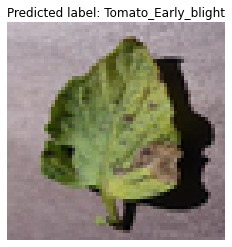

In [19]:
plt.imshow(imgpred)
plt.axis('off')
plt.title("Predicted label: "+labels[itemindex[1][0]])
plt.show()